## RNN text generator using Tensorflow Eager execution
#### code originally was using Keras

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

dataset_filename = 'dataset/holmes.txt'

text = open(dataset_filename).read().lower()
print('orignal text has {} characters'.format(len(text)))

TensorFlow version: 1.7.0
Eager execution: True
orignal text has 581864 characters


In [2]:
def cleanup_text(text):
    punctuation = ['!', ',', '.', ':', ';', '?']

    # get the unique characters in the text
    unique_chars = sorted(list(set(text)))
    for unique_char in unique_chars:
        if unique_char in punctuation:
            continue
        if unique_char >= 'a' and unique_char <= 'z':
            continue
        text = text.replace(unique_char, ' ')

    return text

# remove header and table of contents
text = text[1166:]
text = cleanup_text(text)

# shorten any extra dead space created above
text = text.replace('  ',' ')

In [3]:
# print(text[:1000])

# count the number of unique characters in the text
chars = sorted(list(set(text)))

# print some of the text, as well as statistics
print ("this corpus has " +  str(len(text)) + " total number of characters")
print ("this corpus has " +  str(len(chars)) + " unique characters")
print (chars)

this corpus has 573815 total number of characters
this corpus has 33 unique characters
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## One-hot encoding

In [4]:
# this dictionary is a function mapping each unique character to a unique integer
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer

# this dictionary is a function mapping each unique integer back to a unique character
indices_to_chars = dict((i, c) for i, c in enumerate(chars))  # map each unique integer back to unique character


# function that transforms the input text and window-size into a set of input/output pairs 
def window_transform_text(text, window_size, step_size):
    # containers for input/output pairs
    inputs = []
    outputs = []

    print('len of text:', len(text))
#     num_segments = len(text) // step_size
    num_segments = len(text) - window_size
    print('num_segments:', num_segments)

    for i in range(0, num_segments, step_size):
            inputs.append(text[i:i+window_size])

    for i in range(0, num_segments, step_size):
            offset = window_size+i
            outputs.append(text[offset:offset+1])

    return inputs,outputs

# transform character-based input/output into equivalent numerical versions
def encode_io_pairs(text, window_size, step_size):
    # number of unique chars
    chars = sorted(list(set(text)))
    num_chars = len(chars)
    
    # cut up text into character input/output pairs
    inputs, outputs = window_transform_text(text,window_size,step_size)
#     print(inputs[:10])
#     print(outputs[:10])
#     return
    
    # create empty vessels for one-hot encoded input/output
    X = np.zeros((len(inputs), window_size, num_chars), dtype=np.float32)
    y = np.zeros((len(inputs), num_chars), dtype=np.float32)
    
    # loop over inputs/outputs and tranform and store in X/y
    for i, sentence in enumerate(inputs):
        for t, char in enumerate(sentence):
            X[i, t, chars_to_indices[char]] = 1
        y[i, chars_to_indices[outputs[i]]] = 1
        
    return X,y

In [5]:
# produce input/output pairs
window_size = 100
step_size = 5
X,y = encode_io_pairs(text,window_size,step_size)

print('X.shape:', X.shape)
print('y.shape:', y.shape)

len of text: 573815
num_segments: 573715
X.shape: (114743, 100, 33)
y.shape: (114743, 33)


### Create a model using Keras

The TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together. See the [Keras documentation](https://keras.io/) for details.

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, one [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) and one [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with 'num_chars' nodes each. The first layer's `input_shape` parameter corresponds to the amount of features from the dataset, and is required.

In [6]:
num_chars = len(chars) # our vocabulary, i.e. unique characters in text

def getModel():
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(200, input_shape=(window_size, num_chars)),  # input shape required
#         tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dense(num_chars, activation="softmax"),
    ])
    return model

### Train the model

#### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired output. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy) function which takes the model's prediction and the desired output. The returned loss value is progressively larger as the prediction gets worse.

The `grad` function uses the `loss` function and the [tfe.GradientTape](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/GradientTape) to record operations that compute the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model.

In [7]:
def loss(model, x, y):
    y_ = model(x)
    return tf.keras.losses.categorical_crossentropy(y, y_)



In [8]:
def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

#### Define the optimizer
TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. 

In [9]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001, epsilon=1e-08)

#### Training the model

In [10]:
import time

num_epochs = 50
batch_size = 500

# a small subset of our input/output pairs
Xsmall = X[:100000,:,:]
ysmall = y[:100000,:]

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

training_dataset = tf.data.Dataset.from_tensor_slices((Xsmall, ysmall))
training_dataset = training_dataset.batch(batch_size)
print(training_dataset)

model = getModel()

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    startTime = time.time()
    # training using batches of 'batch_size'
    for X, y in tfe.Iterator(training_dataset):
        grads = grad(model, X, y)
        optimizer.apply_gradients(zip(grads, model.variables), 
                                 global_step=tf.train.get_or_create_global_step())
        epoch_loss_avg(loss(model, X, y)) # batch loss
        epoch_accuracy(model(X), y)
        
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%} - in: {:.3f} sec.".format(epoch, 
                                                                    epoch_loss_avg.result(), 
                                                                    epoch_accuracy.result(),
                                                                    (time.time()-startTime)))        


<BatchDataset shapes: ((?, 100, 33), (?, 33)), types: (tf.float32, tf.float32)>
Epoch 000: Loss: 2.736, Accuracy: 0.000% - in: 895.857 sec.
Epoch 001: Loss: 2.267, Accuracy: 0.000% - in: 894.143 sec.
Epoch 002: Loss: 2.090, Accuracy: 0.000% - in: 827.263 sec.
Epoch 003: Loss: 1.969, Accuracy: 0.000% - in: 814.955 sec.
Epoch 004: Loss: 1.876, Accuracy: 0.000% - in: 816.137 sec.
Epoch 005: Loss: 1.801, Accuracy: 0.000% - in: 817.035 sec.
Epoch 006: Loss: 1.738, Accuracy: 0.000% - in: 817.922 sec.
Epoch 007: Loss: 1.682, Accuracy: 0.000% - in: 817.942 sec.
Epoch 008: Loss: 1.630, Accuracy: 0.000% - in: 818.598 sec.
Epoch 009: Loss: 1.582, Accuracy: 0.000% - in: 819.252 sec.
Epoch 010: Loss: 1.536, Accuracy: 0.000% - in: 819.149 sec.
Epoch 011: Loss: 1.493, Accuracy: 0.000% - in: 819.292 sec.
Epoch 012: Loss: 1.451, Accuracy: 0.000% - in: 820.009 sec.
Epoch 013: Loss: 1.410, Accuracy: 0.000% - in: 820.433 sec.
Epoch 014: Loss: 1.371, Accuracy: 0.000% - in: 820.718 sec.
Epoch 015: Loss: 1.3

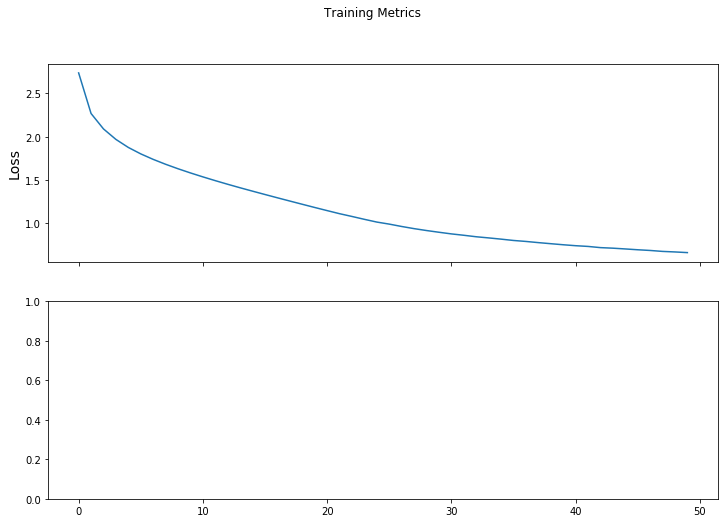

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

# axes[1].set_ylabel("Accuracy", fontsize=14)
# axes[1].set_xlabel("Epoch", fontsize=14)
# axes[1].plot(train_accuracy_results)

plt.show()

#### Save model to a file

In [15]:
model_filepath = 'models/model_large_window_100.hdfs'

tf.keras.models.save_model(
    model,
    model_filepath,
    overwrite=True,
    include_optimizer=True
)

#### Generate text utilities

In [12]:
# function that uses trained model to predict a desired number of future characters
def predict_next_chars(model,input_chars,num_to_predict):     
    # create output
    predicted_chars = ''
    for i in range(num_to_predict):
        # convert this round's predicted characters to numerical input    
        x_test = np.zeros((1, window_size, len(chars)), dtype=np.float32)
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1.

        x_test = tf.convert_to_tensor(x_test)

        # make this round's prediction
        test_predict = model(x_test)

        # translate numerical prediction back to characters
        r = np.argmax(test_predict)                           # predict class of each test input
        d = indices_to_chars[r] 

        # update predicted_chars and input
        predicted_chars+=d
        input_chars+=d
        input_chars = input_chars[1:]
    return predicted_chars

In [14]:
start_inds = [2200, 2400, 2600]

for s in start_inds:
    start_index = s
    input_chars = text[start_index: start_index + window_size]

    # use the prediction function
    predict_input = predict_next_chars(model, input_chars, num_to_predict = 100)

    # print out input characters
    print('------------------')
    input_line = 'input chars = ' + '\n' +  input_chars + '"' + '\n'
    print(input_line)

    # print out predicted characters
    line = 'predicted chars = ' + '\n' +  predict_input + '"' + '\n'
    print(line)

------------------
input chars = 
d finally of the mission which he had accomplished so delicately and successfully for the reigning f"

predicted chars = 
angs in the onder said he, and then he was dear doust, and little here be the subble to the othere w"

------------------
input chars = 
aders of the daily press, i knew little of my former friend and companion. one night it was on the t"

predicted chars = 
hat hes and like a room realonge. i shopld to the beld which has been do through the stone plate the"

------------------
input chars = 
actice , when my way led me through baker street. as i passed the well remembered door, which must a"

predicted chars = 
 cound spolles stall bark and surpoish of the recimonative a susifelf the hand of the mather pase st"

